In [6]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
%autoreload
#from model import SSVAE
import train_utils

In [3]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import matplotlib.cm as cm
import numpy as np
from tqdm import tqdm
from collections import Counter
%matplotlib inline

In [4]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

In [5]:
device = torch.device("cuda")

# Read MWD dataset

In [8]:
import pickle

In [9]:
[dataframes, df_labels, df_names] = pickle.load(open('mwd_data.pkl', 'rb'))

In [10]:
data = []
labels = []
names = []
L = 6*(30) # 6*(m) where m is amount of minutes to slice
step = 6*(3)
for i in range(len(dataframes)):
    for s in range(L, len(dataframes[i]), step):
        data.append(dataframes[i][s - L:s].values)
        labels.append(df_labels[i])
        names.append(df_names[i])
data = np.array(data)
labels = np.array(labels)
names = np.array(names)

In [11]:
# center all timeseries in all entries separately
for f in range(data.shape[2]):
    data[:, :, f] = (data[:, :, f].T - data[:, :, f].mean(axis=1)).T 

# scale all timeseries in all entries jointly
for f in range(data.shape[2]):
    data[:, :, f] = data[:, :, f]/data[:, :, f].ravel().std()

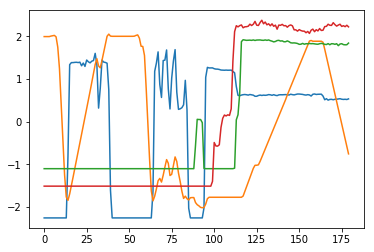

In [13]:
plt.plot(data[2]);

In [14]:
label_id = {}
for label in Counter(labels):
    if label != 'nan':
        label_id[label] = len(label_id)
num_labels = len(label_id)
label_id['nan'] = num_labels
num_labels

6

In [15]:
N = len(data)
N

31352

In [16]:
target_features =['f1', 'f2', 'f3', 'f4']

In [17]:
full_labels = np.array([label_id[label] for label in labels])
corrupted_labels = np.array(full_labels)
np.random.seed(0)
corrupted_labels[np.random.choice(len(corrupted_labels), int(0.5*len(corrupted_labels)), replace=False)] = num_labels

In [18]:
batch_size = 512

In [19]:
train_inds = np.arange(int(N*5/6))
test_inds = np.arange(int(N*5/6), N)

In [20]:
len(train_inds), len(test_inds)

(26126, 5226)

In [21]:
data_tensor = torch.stack([torch.Tensor(x) for x in data])

In [22]:
corrupted_labels_tensor = torch.Tensor(corrupted_labels).long()
full_labels_tensor = torch.Tensor(full_labels).long()

In [23]:
ts_dataset_train = torch.utils.data.TensorDataset(data_tensor[train_inds], 
                                                  corrupted_labels_tensor[train_inds], 
                                                  full_labels_tensor[train_inds])
ts_dataset_test = torch.utils.data.TensorDataset(data_tensor[test_inds], 
                                                 corrupted_labels_tensor[test_inds], 
                                                 full_labels_tensor[test_inds])

In [24]:
train_loader = torch.utils.data.DataLoader(ts_dataset_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(ts_dataset_test, batch_size=batch_size, shuffle=True)

# Fit models

In [25]:
epochs = 1000
LOGS = 5

In [ ]:
m, trl, tel, mse, iwae = train_utils.fit_model_report('semi', True,  target_features, num_labels, 
                                                        2, L, device, 1000, 
                                                        train_loader, test_loader, 'mwdr', 100)

conv size: 300
fc3 8 40
number of model parameters: 19518
====> Train set loss: 14272.9712, MSE: 135.2399, CE: 1.2464, CE(full): 1.2511, KL: 2.3193
====> Train set loss: 12481.1572, MSE: 117.5065, CE: 1.2165, CE(full): 1.2243, KL: 1.2036
====> Train set loss: 12375.2279, MSE: 116.3957, CE: 1.2254, CE(full): 1.2281, KL: 0.8694
====> Train set loss: 11179.6850, MSE: 104.5367, CE: 1.2095, CE(full): 1.2164, KL: 0.6340
====> Train set loss: 12324.2405, MSE: 116.0045, CE: 1.2056, CE(full): 1.2114, KL: 0.8626
====> Train set loss: 11239.6622, MSE: 105.1924, CE: 1.2000, CE(full): 1.2016, KL: 0.8390
====> Train set loss: 11505.8217, MSE: 107.8162, CE: 1.2069, CE(full): 1.2095, KL: 0.1626
====> Train set loss: 12139.4169, MSE: 114.1949, CE: 1.1994, CE(full): 1.2113, KL: 0.6106
====> Train set loss: 10594.6636, MSE: 98.7649, CE: 1.1966, CE(full): 1.2023, KL: 0.3939
====> Train set loss: 10336.3869, MSE: 96.1317, CE: 1.2052, CE(full): 1.2086, KL: 0.1359
epoch: 100
====> Test set loss: 16606.0508, 

# Plot results

In [ ]:
def plot2d_latent(log, fname, title=None):
    if title is None:
        title=fname
    plt.figure(figsize=(3*LOGS, 3))
    for i in range(LOGS):
        plt.subplot(1, LOGS, i + 1)
        m, trl, tel, mse, iwae = log[i]
        _, mu, logvar, _ = m(ts_dataset_train[:len(ts_dataset_train)][0].to(device))
        plt.scatter(mu.to(torch.device("cpu")).data.numpy()[:, 0], mu.to(torch.device("cpu")).data.numpy()[:, 1], 
                    s=2, c=ts_dataset_train[:len(ts_dataset_train)][2], cmap=cm.rainbow)
        plt.xticks([])
        plt.yticks([])
        plt.xlabel('z0')
        plt.ylabel('z1')

        plt.title(f'seed: {i}')
    plt.suptitle(title, fontsize=16, y=1.05)
    plt.tight_layout()
    plt.savefig(f'{fname}.png', dpi=300, bbox_to_anchor=(1, 1), bbox_inches='tight')

In [ ]:
def plot_loss(ts, label, c):
    ts = np.array(ts)
    mean = np.mean(ts, axis=0)
    R = np.max(ts, axis=0)
    L = np.min(ts, axis=0)
    plt.plot(np.arange(0, epochs, 100), mean, label=label, color=c)
    plt.plot(np.arange(0, epochs, 100), R, color=c, linestyle='--', lw=1, alpha=0.5)
    plt.plot(np.arange(0, epochs, 100), L, color=c, linestyle='--', lw=1, alpha=0.5)

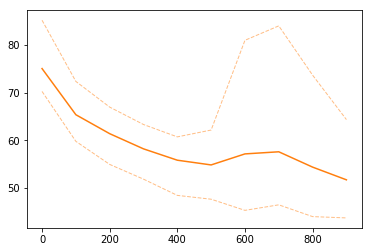

In [114]:
plt.figure(figsize=(8, 5))

plt.title('Test',fontsize=16)
plot_loss(mse, 'semi-supervised MWD', 'C0')
plt.xlabel('epoch',fontsize=16)
plt.ylabel('~ MSE',fontsize=16)
lgd = plt.legend(loc=2, bbox_to_anchor=(1,
                                        1.0), fontsize=16)
plt.savefig('mse_loss_results_MWD.png', dpi=300, bbox_to_anchor=(1, 1), bbox_extra_artists=(lgd,), bbox_inches='tight')

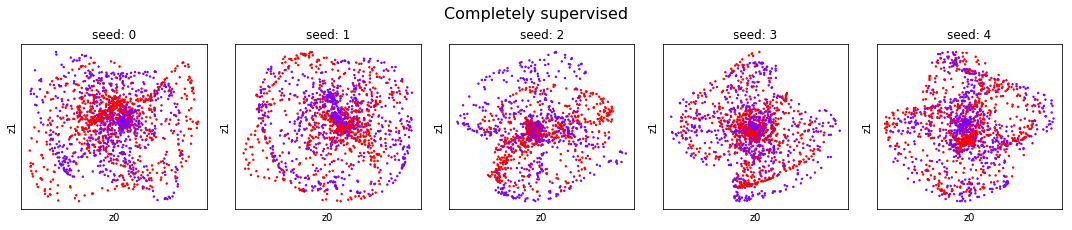

In [115]:
plot2d_latent([(m, trl, tel, mse, iwae)], 'semi_latent_mwd', 'MWD')